# Retinal pyramid and addition of saccades


To imitate a retinal transformation on a image, we can mimic a fovea in the center (high density of cones and a batter definition) and on the edges high density of rods (lower definition). 
To achieve it we used two differents methods :
1. Log-Gabor filters 
2. The Laplacian pyramid

Then to recreate a complete image, we add the saccades : the eye is moving, and when we combine the images together we get a visual scene on which only the points of interest are sharp. These are the two last parts of this notebook, to do it we used the Laplacian pyramid method to work with color.
3. Adding the saccades
4. Reconstructing the visual field

## 1. Log-Gabor filters

2020-02-07_retina_warp 

2020-02-07_retina-saccades-tests 

2020-02-17_retina_reconstruction 

b&w 

## 2. The Laplacian pyramid

### 2.1. Initialization parameters & libraries

Parameters :

In [1]:
mode= 'bilinear' #resizing : continuous transition, reduces edges,contrast
width = 32 #side of the cropped image used to build the pyramid
base_levels = 1.61803
base_levels = 2 #downsampling/upsampling factor

N_batch = 4 #number of images 
pattern = 'i05june05_static_street_boston_p1010808'

Libraries :

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [3]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [4]:
#%load_ext watermark
#%watermark -i -h -m -v -p numpy,torch,POLO  -r -g -b

### 2.2. Loading an image

In [5]:
from PIL import Image

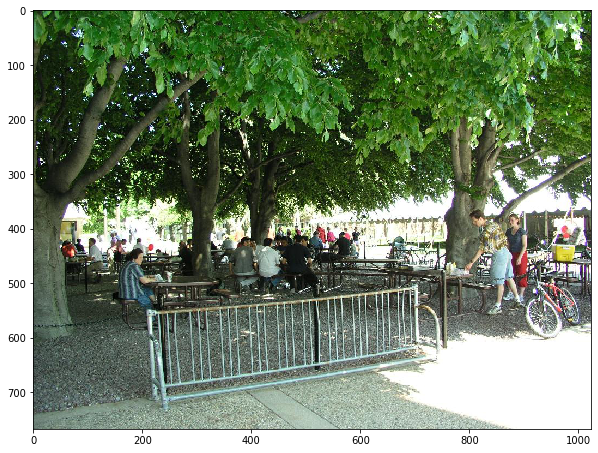

In [6]:
img_orig = Image.open('../data/i05june05_static_street_boston_p1010808.jpeg')

im_color_npy = np.asarray(img_orig)
N_X, N_Y, _ = im_color_npy.shape #dimensions 

ds= 1


fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im_color_npy)



### 2.3. Converting to a tensor format
In order to interpolate and build the pyramid we need to work with tensors : the image is converted using the module Pytorch.

In [7]:
img_tens = torch.Tensor(im_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)
print('Tensor shape=', img_tens.shape) #image's size stored in img_tens.shape[-2:] 

Tensor shape= torch.Size([1, 3, 768, 1024])


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### 2.4. Using torch to build up a Laplacian pyramid


https://www.cs.tau.ac.il/~dcor/Graphics/Exercises/burt83laplacian.pdf


To build the pyramid we down-sample recursively, until the image's size is 32*32.

The scale factor is 1/2 : for each iteration the image size is reduced by half.
https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate

In [8]:
from torch.nn.functional import interpolate 

In [9]:
%%timeit
img_down = interpolate(img_tens, scale_factor=1/2, mode=mode) 
#print(img_down.shape)

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


23.5 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


torch.Size([384, 512, 3])


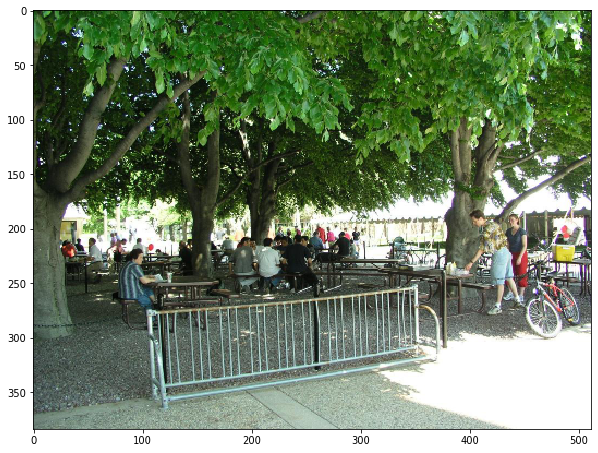

In [10]:
img_down = interpolate(img_tens, scale_factor=1/2, mode=mode) #interpolating
img_aff = img_down.permute(0,2,3,1)[0,:,:,:] # Permuting the tensors dimensions to deal with color 
print(img_aff.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_aff.numpy().astype('uint'))
#ax.plot(N_Y//2, N_X//2, 'r+', ms=32);

In [11]:
img_down = img_tens.clone() 
n_levels = 0
while max(img_down.shape[-2:]) > width : # until obtaining sides inferior to width (cf cropped image at each step) 
    n_levels += 1 
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels) #each iteration reduces the image's size by a factor defined by base_levels
    #print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) # downsampling 1/base_levels (bilinear mode)
n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

Tensor shape= torch.Size([1, 3, 768, 1024]) , n_levels= 1
Tensor shape= torch.Size([1, 3, 384, 512]) , n_levels= 2
Tensor shape= torch.Size([1, 3, 192, 256]) , n_levels= 3
Tensor shape= torch.Size([1, 3, 96, 128]) , n_levels= 4
Tensor shape= torch.Size([1, 3, 48, 64]) , n_levels= 5
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


In [12]:
img_down = img_tens.clone() 
n_levels = 0
while max(img_down.shape[-2:]) > width : # until obtaining sides inferior to width (cf cropped image at each step) 
    n_levels += 1 
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels) #each iteration reduces the image's size by a factor defined by base_levels
    #print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) # downsampling 1/base_levels (bilinear mode)
n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

Tensor shape= torch.Size([1, 3, 768, 1024]) , n_levels= 1
Tensor shape= torch.Size([1, 3, 384, 512]) , n_levels= 2
Tensor shape= torch.Size([1, 3, 192, 256]) , n_levels= 3
Tensor shape= torch.Size([1, 3, 96, 128]) , n_levels= 4
Tensor shape= torch.Size([1, 3, 48, 64]) , n_levels= 5
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


#### Applying on the central crop of $32\times32$:

In [13]:
def cropped_pyramid(img_tens, width=width, base_levels=base_levels, verbose=False):
    
    N_batch, _, N_X, N_Y = img_tens.shape # tensor of the images  (dimension 4)
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1 #computing the number of iterations cf:downsampling
    
    img_crop = torch.zeros((N_batch, n_levels, 3, width, width)) #creating the tensor to store the cropped images while pyramiding

    img_down = img_tens.clone()
    level_size = [[N_X, N_Y]]
    for i_level in range(n_levels-1): #each iteration -> residual_image = image - downsampled_cloned_image_reshaped_to_the_right_size 
        img_residual = img_down.clone()
        img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) #downsampling
        img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)  #upsizing in order to substract

        if verbose: print('Tensor shape=', img_down.shape, ', shape=', img_residual.shape)
        h_res, w_res = img_residual.shape[-2:] #at each iteration the residual image size is reduced of a factor 1/base_levels (img_down the image downsampled at the previous iteration)

        img_crop[:, i_level, :, :, :] = img_residual[:, :, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)] #the central crop of residual image stored in tensor img_crop
        level_size.append(list(img_down.shape[-2:]))

    h_res, w_res = img_down.shape[-2:]
    img_crop[:, n_levels-1, :, 
             (width//2-h_res//2):(width//2+h_res//2), 
             (width//2-w_res//2):(width//2+w_res//2)] = img_down #[0, :, :, :]
    if verbose: print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels) #print image's dimensions after downsampling, condition max(img_down.shape[-2:])<=width satisfied
    return img_crop, level_size 


#calling the function
img_crop = cropped_pyramid(img_tens, verbose=True)[0]

Tensor shape= torch.Size([1, 3, 384, 512]) , shape= torch.Size([1, 3, 768, 1024])
Tensor shape= torch.Size([1, 3, 192, 256]) , shape= torch.Size([1, 3, 384, 512])
Tensor shape= torch.Size([1, 3, 96, 128]) , shape= torch.Size([1, 3, 192, 256])
Tensor shape= torch.Size([1, 3, 48, 64]) , shape= torch.Size([1, 3, 96, 128])
Tensor shape= torch.Size([1, 3, 24, 32]) , shape= torch.Size([1, 3, 48, 64])
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


In [14]:
img_down.shape

torch.Size([1, 3, 24, 32])

Tensor shape= torch.Size([1, 6, 3, 32, 32])


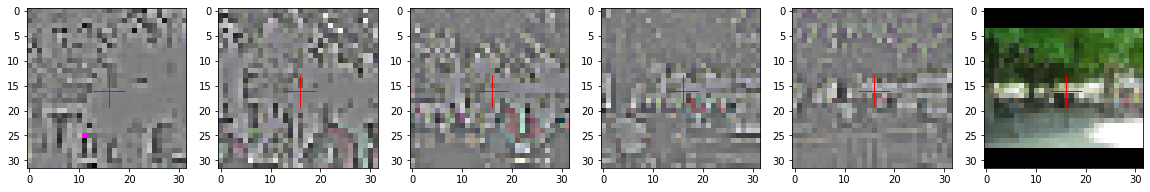

In [15]:
#displaying central crops from successive residual images
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
img_aff = img_crop.permute(0,1,3,4,2).numpy()
for i_level, ax in enumerate(axs):
    if i_level < n_levels-1:
        bias = 128
    else:
        bias = 0
    ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)  

In [16]:
img_crop.shape

torch.Size([1, 6, 3, 32, 32])

### 2.5. Reconstruction
### Inverse pyramid from the coefficients
Once the pyramid is done we can create the reconstructed image.

In [17]:
def inverse_pyramid(img_crop, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = img_crop.shape[0] 
    width = img_crop.shape[3] 
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1 #number of cropped images = levels of the pyramid
    
    img_rec = img_crop[:, -1, :, :, :] #.unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, :, 
                (h_res//2-width//2):(h_res//2+width//2), 
                (w_res//2-width//2):(w_res//2+width//2)] += img_crop[:, i_level, :, :, :] #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

img_rec = inverse_pyramid(img_crop)

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


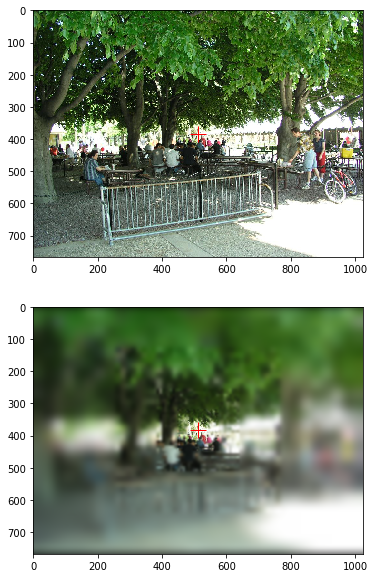

In [18]:
#Plotting reconstructed image
fig, axs = plt.subplots(2, 1, figsize=(10,10))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    img = img.permute(0,2,3,1)[0,:,:,:]
    ax.imshow(img.numpy().astype('uint8'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

## 3. Adding the saccades
For this image we have an array containing the different points of interest covered by an eye using saccades.

In [19]:
mode= 'bilinear' #resizing : continuous transition, reduces edges,contrast
width = 32 #side of the cropped image used to build the pyramid
base_levels = 2 #downsampling/upsampling factor

In [20]:
name = 'i05june05_static_street_boston_p1010808'
impath = '../data/'+name+'.jpeg'
locpath = '../data/'+name+'.pkl'

### 3.1. Sliding gaze 
First we "roll" the image to place the point of interest in the center, as though the eye was moving. This way the image keeps the same dimension.

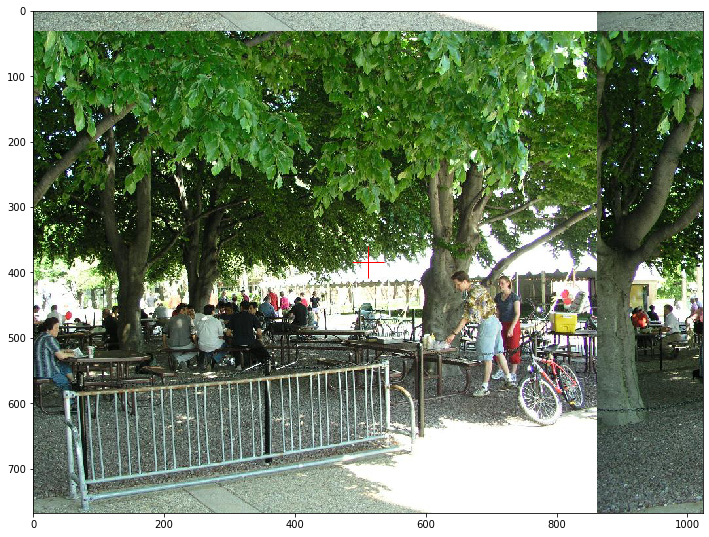

In [21]:
im_color_npy = np.roll(im_color_npy, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
im_color_npy = np.roll(im_color_npy, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom


fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(im_color_npy)
ax.plot(N_Y//2, N_X//2, 'r+', ms=32);

In [22]:
import pickle
f = open(locpath,'rb')
loc_dict = pickle.load(f) # coordinates of the points of interest
loc_dict

{'image_name': 'i05june05_static_street_boston_p1010808',
 'barycenters': [(498, 384),
  (192, 425),
  (857, 437),
  (949, 513),
  (585, 546),
  (486, 288),
  (648, 415)]}

### 3.2. Saccade path

In [23]:
im_color_npy = np.asarray(img_orig)
img_tens = torch.Tensor(im_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)
print('Tensor shape=', img_tens.shape) #converting to a tensor format, image's size stored in img_tens.shape[-2:]

Tensor shape= torch.Size([1, 3, 768, 1024])


In [24]:
loc_data_xy = np.array(loc_dict['barycenters'])
loc_data_ij = []
for coord in loc_data_xy:
    loc_data_ij += [[coord[1], coord[0]]]
loc_data_ij = np.array(loc_data_ij)
print(loc_data_xy)
print(loc_data_ij)

[[498 384]
 [192 425]
 [857 437]
 [949 513]
 [585 546]
 [486 288]
 [648 415]]
[[384 498]
 [425 192]
 [437 857]
 [513 949]
 [546 585]
 [288 486]
 [415 648]]


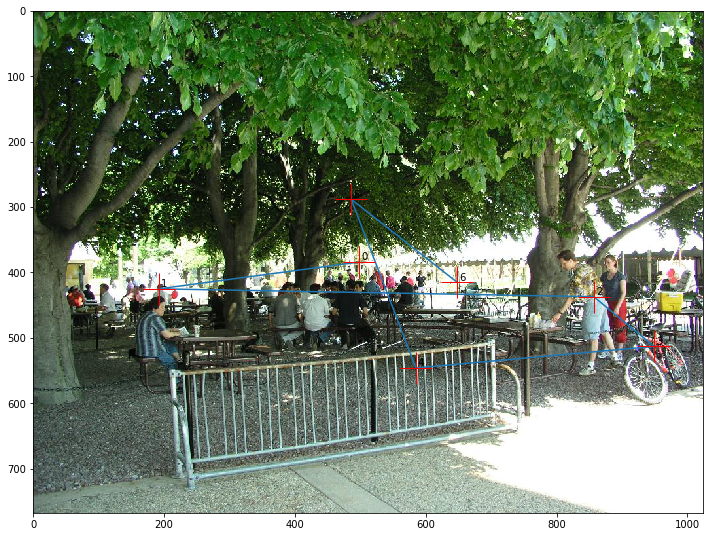

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(im_color_npy, cmap='gray')

ax.plot(loc_data_xy[:,0], loc_data_xy[:,1])
for i, coord in enumerate(loc_data_xy):
    ax.plot(coord[0], coord[1], 'r+', ms=32)
    ax.text(coord[0]+3, coord[1]-3, i)

In [26]:
orig = np.zeros(2, dtype='int')
orig[0] = N_X//2
orig[1] = N_Y//2
print("Coordinates of the center : ", orig) 

Coordinates of the center :  [384 512]


Using the roll function to create images centered on the successive focal points :
https://numpy.org/doc/stable/reference/generated/numpy.roll.html

In [27]:
def saccade_to(img_color, orig, loc_data_ij): 
    img_copy = np.copy(img_color)
    img_copy=np.roll(img_copy, orig[0] - loc_data_ij[0], axis=0)
    img_copy=np.roll(img_copy, orig[1] - loc_data_ij[1], axis=1)
    return img_copy  

img_color_roll=[]
shift=[]
for i in range(len(loc_data_ij)):
    img_color_copy=im_color_npy.copy()
    #shift.append([im_color_npy.shape[0]-loc_data[i][1], im_color_npy.shape[1]-loc_data[i][0]])
    #print('i=', i, 'l initial=', shift[-1][0], 'c initial=', shift[-1][1])
    img_color_copy=np.roll(img_color_copy, orig[0] - loc_data_ij[i][0], axis=0)
    img_color_copy=np.roll(img_color_copy, orig[1] - loc_data_ij[i][1], axis=1)
    img_color_roll.append(img_color_copy)

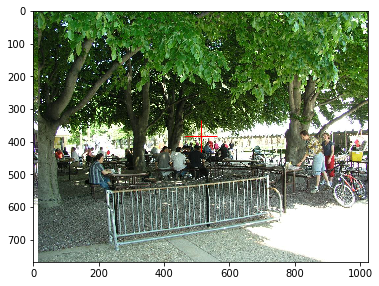

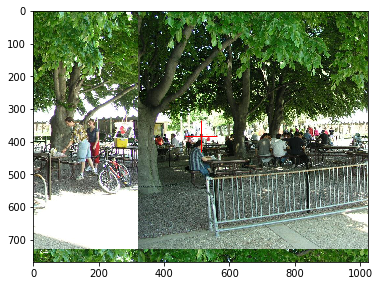

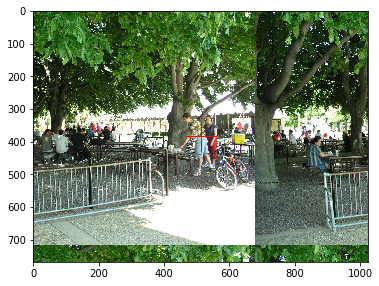

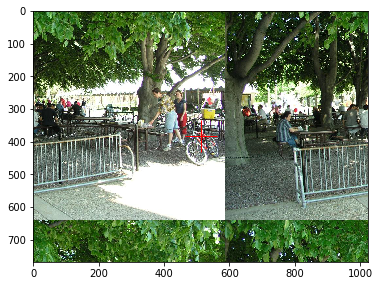

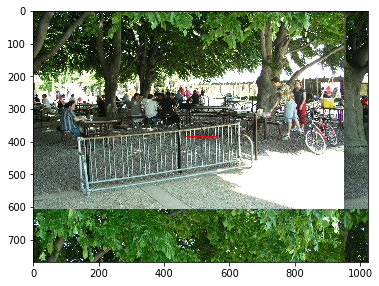

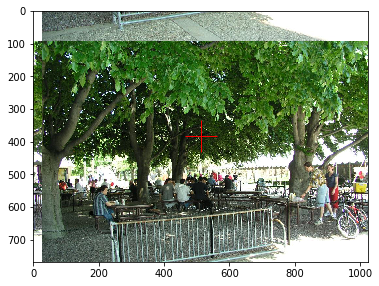

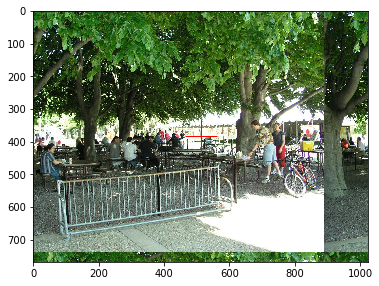

In [28]:
img_color_roll=[]
for i in range(len(loc_data_ij)):
    plt.figure(figsize=(6,6))
    #plt.imshow(img_color_roll[i])
    im_color_sac = saccade_to(im_color_npy, (N_X//2, N_Y//2), loc_data_ij[i])
    plt.imshow(im_color_sac)
    plt.plot(orig[1], orig[0], 'r+', ms=32)
    img_color_roll.append(im_color_sac)

In [32]:
#Computing number of iterations to downsample the image to a size < width
n_levels = int(np.log(np.max(im_color_npy.shape)/width)/np.log(base_levels)) + 1 
print('Computed n_levels=', n_levels)

Computed n_levels= 6


In [33]:
#N_batch, _, N_X, N_Y = img_tens.shape
#level_size = [[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]
#print(level_size)

In [34]:
img_color_pyr_tens=[]
for i in range(len(loc_data_ij)):
    img_tens = torch.Tensor(img_color_roll[i][None, ...]) 
    img_tens = img_tens.permute(0,3,1,2)
    img_crop, level_size = cropped_pyramid(img_tens, verbose=False)
    img_color_pyr_tens.append(img_crop)
print(level_size)

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


[[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]


In [35]:
img_rec = inverse_pyramid(img_crop)

Plotting reconstructed image :

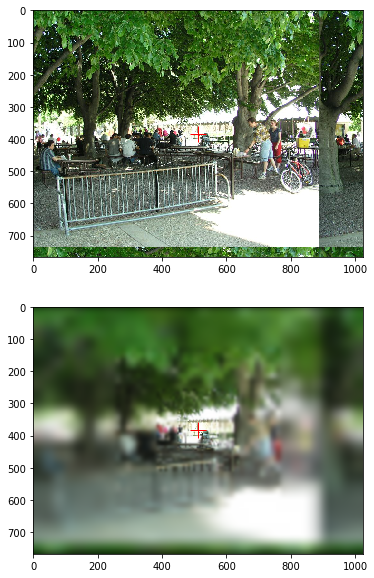

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    img = img.permute(0,2,3,1)[0,:,:,:]
    ax.imshow(img.numpy().astype('uint8'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

### 3.3 Reconstruction from multiple saccades

Creating all the images rolled according to saccade data, and using the Laplacian pyramid.

In [37]:
img_color_pyr_rec=[]
for i in range(len(loc_data_ij)):
    img_color_pyr_rec.append(inverse_pyramid(img_color_pyr_tens[i], verbose=True))
 

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])


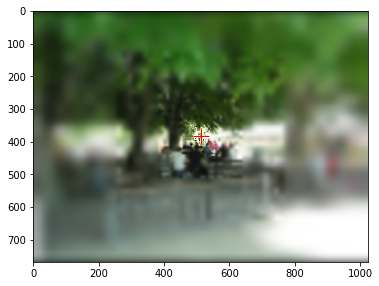

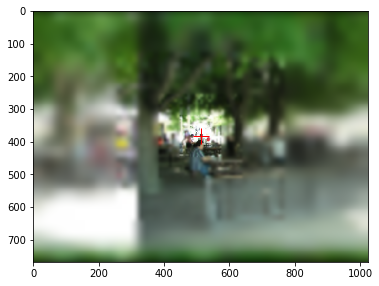

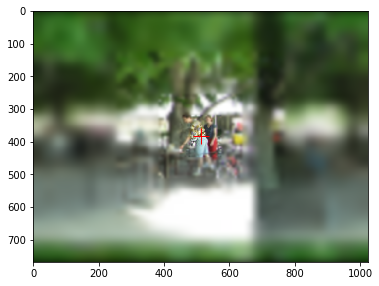

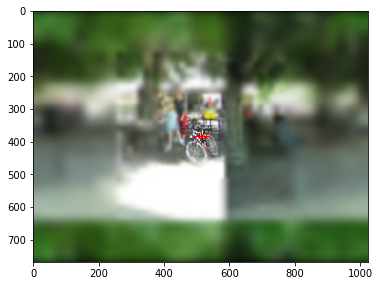

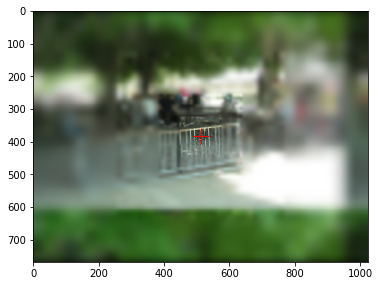

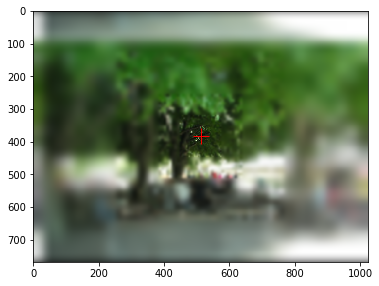

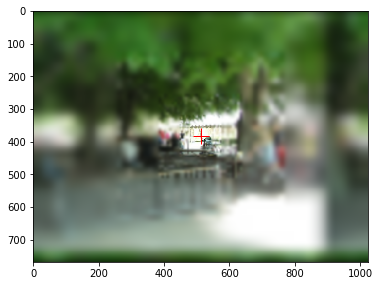

In [38]:
for i, img in enumerate(img_color_pyr_rec):
    plt.figure(figsize=(6,6))
    img_color_pyr_npy = img_color_pyr_rec[i].detach()  
    print(img_color_pyr_npy.shape)
    img_color_pyr_npy = img_color_pyr_npy.permute(0,2,3,1)[0,:,:,:]
    plt.imshow(img_color_pyr_npy.numpy().astype('uint8'))
    plt.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

In [39]:
def tens_saccade_to(img_color_tens, orig, loc_data_ij): 
    img_copy = torch.clone(img_color_tens)
    img_copy = torch.roll(img_copy, (orig[0] - loc_data_ij[0],), (2,))
    img_copy = torch.roll(img_copy, (orig[1] - loc_data_ij[1],), (3,))
    return img_copy 

In [40]:
loc_data_ij[0] // 2**5

array([12, 15], dtype=int32)

In [41]:
def level_construct(img_crop_list, loc_data_ij, level_size, level):
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    orig = level_size[0]//2, level_size[1]//2
    img_lev = torch.zeros((1, 3, level_size[0], level_size[1]))
    img_div = torch.zeros((1, 3, level_size[0], level_size[1]))
    #print(img_lev.shape)
    nb_saccades = len(img_crop_list)
    for num_saccade in range(nb_saccades):
        sac_img =  img_crop_list[num_saccade][:, level, :, :, :]
        if level_size[0] < width:
            x_width = level_size[0]
            sac_img = sac_img[:,:,width//2 - level_size[0]//2:width//2 + level_size[0]//2,:]
        else:
            x_width = width  
        if level_size[1] < width:
            y_width = level_size[1]
            sac_img = sac_img[:,:,:,width//2 - level_size[1]//2:width//2 + level_size[1]//2]  
        else:
            y_width = width
        #print(sac_img.shape)
            
        loc = loc_data_ij[num_saccade] // 2**level
        img_lev = tens_saccade_to(img_lev, orig, loc)
        img_lev[:,:,orig[0]-x_width//2:orig[0]+x_width//2, orig[1]-y_width//2:orig[1]+y_width//2] += sac_img 
        img_lev = tens_saccade_to(img_lev, loc, orig)
        img_div = tens_saccade_to(img_div, orig, loc)
        img_div[:,:,orig[0]-x_width//2:orig[0]+x_width//2, orig[1]-y_width//2:orig[1]+y_width//2] += torch.ones_like(sac_img) 
        img_div = tens_saccade_to(img_div, loc, orig)
    # coefficients normalization    
    indices_zero = (img_div == 0).nonzero().detach().numpy()
    img_div_npy = img_div.detach().numpy()
    for ind in indices_zero:
        img_div_npy[ind[0], ind[1], ind[2], ind[3]] = 1
    img_lev = img_lev // img_div_npy
    plt.figure()
    if level < n_levels-1:
        bias = 128
    else:
        bias = 0
    img_aff = img_lev.detach().permute(0,2,3,1)[0,:,:,:].numpy()
    plt.imshow((img_aff+bias).astype('uint8'))
    return img_lev
    

In [45]:
def inverse_pyramid_saccades(img_crop_list, loc_data_ij, level_size, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = img_crop.shape[0] 
    width = img_crop.shape[3] 
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    
    #img_rec = img_crop[:, -1, :, :, :] #.unsqueeze(1)
    img_rec = level_construct(img_crop_list, loc_data_ij, level_size[n_levels-1], level=n_levels-1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_lev = level_construct(img_crop_list, loc_data_ij, level_size[i_level], level=i_level)
        img_rec += img_lev #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

The cropped images are layed on a blank image of the original image dimensions. 

On this array we can reconstruct the visual field, the eye travels the scene using saccades.

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


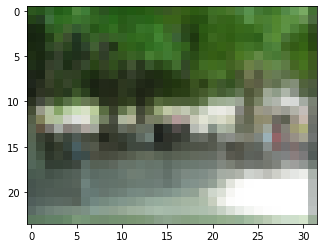

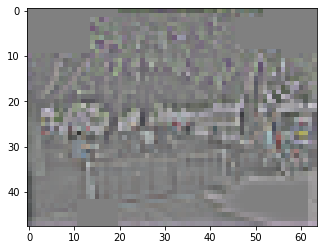

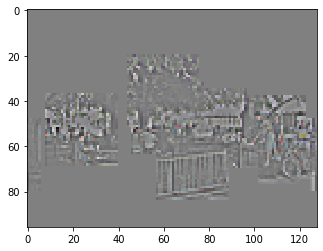

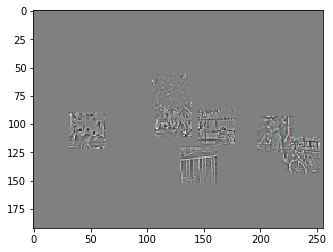

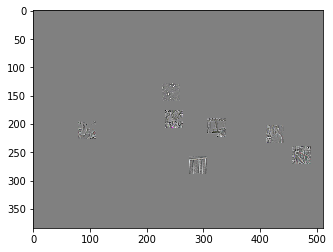

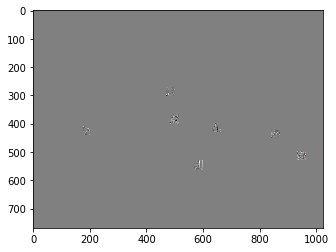

In [43]:
img_sac = inverse_pyramid_saccades(img_color_pyr_tens, loc_data_ij, level_size, verbose=True)

## 4. Reconstructing the visual field
Using the multiple saccades and the pyramid only, the visual result is in color, and better than when using log-gabor filters. 
However, the 32*32 squares are visible (overlapped cropped images, not continuous), and further from the eye's biological functionning.

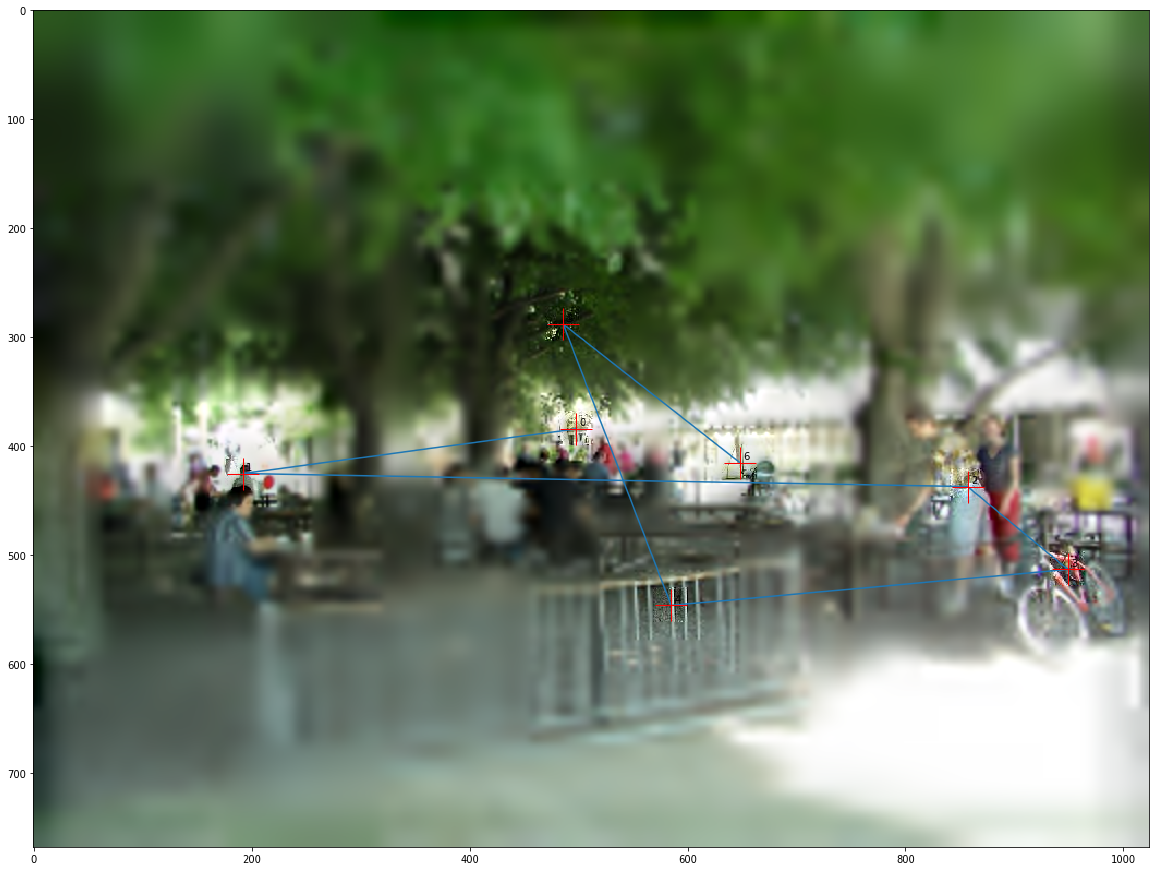

In [44]:
plt.figure(figsize=(20,20))
im = img_sac.detach().permute(0,2,3,1)[0,:,:,:].numpy()
im = np.clip(im,0,255).astype('uint8')

plt.imshow(im)
plt.plot(loc_data_ij[:,1], loc_data_ij[:,0])
for i, coord in enumerate(loc_dict['barycenters']):
    plt.plot(coord[0], coord[1], 'r+', ms=32)
    plt.text(coord[0]+3, coord[1]-3, i)